<a href="https://colab.research.google.com/github/nv-hiep/Autoencoders/blob/main/Stacked_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Reshape, Input
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Dropout, ActivityRegularization
from keras.layers import LSTM, RepeatVector, TimeDistributed, GaussianNoise

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'autoencoders'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    # plt.axis('off')

# Stacked Autoencoder

In [6]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [7]:
X_train_full = X_train_full / 255.
X_test       = X_test / 255.

In [8]:
print('X_train_full.shape: ', X_train_full.shape)
print('y_train_full.shape: ', y_train_full.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train_full.shape:  (60000, 28, 28)
y_train_full.shape:  (60000,)
X_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)


In [9]:
train_size = 50_000

In [10]:
X_train = X_train_full[:train_size]
X_valid = X_train_full[train_size:]

y_train = y_train_full[:train_size]
y_valid = y_train_full[train_size:]

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_valid.shape: ', X_valid.shape)
print('y_valid.shape: ', y_valid.shape)

X_train.shape:  (50000, 28, 28)
y_train.shape:  (50000,)
X_valid.shape:  (10000, 28, 28)
y_valid.shape:  (10000,)


Just like other neural networks we have discussed, autoencoders can have multiple hidden layers. In this case they are called stacked autoencoders (or deep autoencoders). Adding more layers helps the autoencoder learn more complex codings. That said, one must be careful not to make the autoencoder too powerful. Imagine an encoder so powerful that it just learns to map each input to a single arbitrary number (and the decoder learns the reverse mapping). Obviously such an autoencoder will reconstruct the training data perfectly, but it will not have learned any useful data representation in the process (and it is unlikely to generalize well to new instances).

The architecture of a stacked autoencoder is typically symmetrical with regard to the central hidden layer (the coding layer). To put it simply, it looks like a sandwich. For example, an autoencoder for MNIST (introduced in Chapter 3) may have 784 inputs, followed by a hidden layer with 100 neurons, then a central hidden layer of 30 neurons, then another hidden layer with 100 neurons, and an output layer with 784 neurons. This stacked autoencoder is represented in Figure 17-3.

Build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders):

Output Layer (Units: 784) -> Reconstruction

Hidden 3 (Units: 100)

Hidden 2 (Units: 30) -> Codings

Hidden 1 (Units: 100)

Input Layer (Units: 784) 

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = Sequential()
encoder.add(Flatten(input_shape=[28,28]))
encoder.add(Dense(100, activation='selu'))
encoder.add(Dense(30, activation='selu'))

decoder = Sequential()
decoder.add(Dense(100, activation='selu', input_shape=[30]))
decoder.add(Dense(28*28, activation='sigmoid'))
decoder.add(Reshape([28,28]))

autoencoder = Sequential([encoder, decoder])
autoencoder.compile(loss='binary_crossentropy', optimizer=SGD(0.15), metrics=['binary_accuracy'])

In [16]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [17]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = autoencoder.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1563/1563 [==============================] - 19s 3ms/step - loss: 0.5264 - binary_accuracy: 0.4442 - val_loss: 0.3708 - val_binary_accuracy: 0.4937
Epoch 2/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3640 - binary_accuracy: 0.4977 - val_loss: 0.3480 - val_binary_accuracy: 0.4974
Epoch 3/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3417 - binary_accuracy: 0.5019 - val_loss: 0.3321 - val_binary_accuracy: 0.5000
Epoch 4/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3276 - binary_accuracy: 0.5044 - val_loss: 0.3237 - val_binary_accuracy: 0.5009
Epoch 5/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3212 - binary_accuracy: 0.5039 - val_loss: 0.3191 - val_binary_accuracy: 0.5015
Epoch 6/20
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3166 - binary_accuracy: 0.5049 - val_loss: 0.3160 - val_binary_accuracy: 0.5021
Epoch 7/20
1563/1563 [=============================

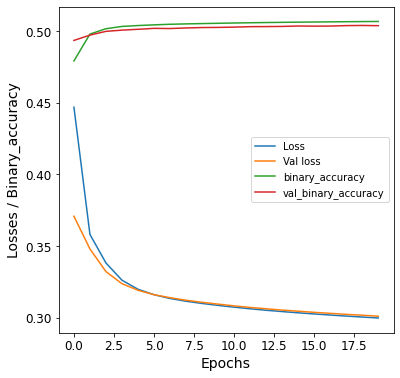

In [13]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

In [14]:
def show_reconstructions(model, images=X_test, n_images=5):
  '''
  First row: real images
  Second row: reconstructed images
  '''
  reconstructions = model.predict(images[:n_images])

  plt.figure(figsize=(n_images * 1.5, 3))
  # plt.title('Image reconstruction from Stacked Autoencoder')
  for img_id in range(n_images):
    plt.subplot(2, n_images, 1 + img_id)
    plot_image(images[img_id])
    plt.subplot(2, n_images, 1 + n_images + img_id)
    plot_image(reconstructions[img_id])
  plt.show()

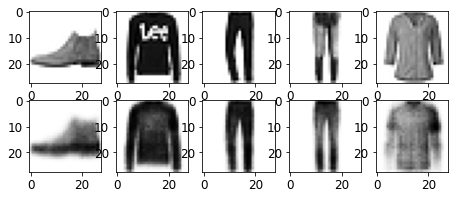

In [15]:
show_reconstructions(autoencoder, images=X_test)